In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

import colors, plot_func, helpers, file_helpers, experiments

## Supervisor

In [2]:
import SupervisorClass
importlib.reload(SupervisorClass)
from SupervisorClass import SupervisorClass

Sprvsr = SupervisorClass()
# Sprvsr.init_dataset()

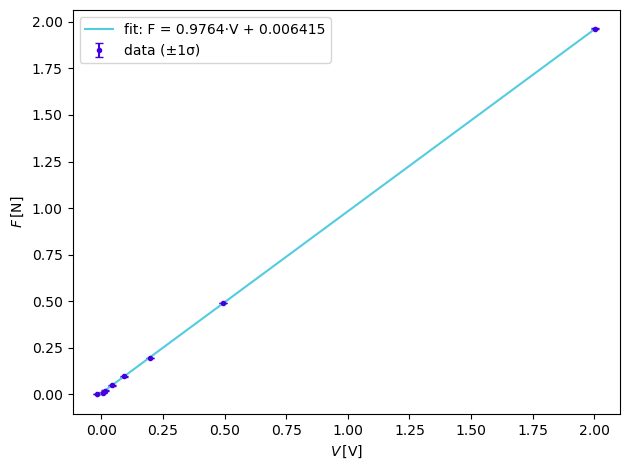

In [3]:
importlib.reload(file_helpers)

import ForsentekClass
importlib.reload(ForsentekClass)
from ForsentekClass import ForsentekClass

Snsr = ForsentekClass()

## Check force

Text(0, 0.5, '$F\\,[\\mathrm{N}]$')

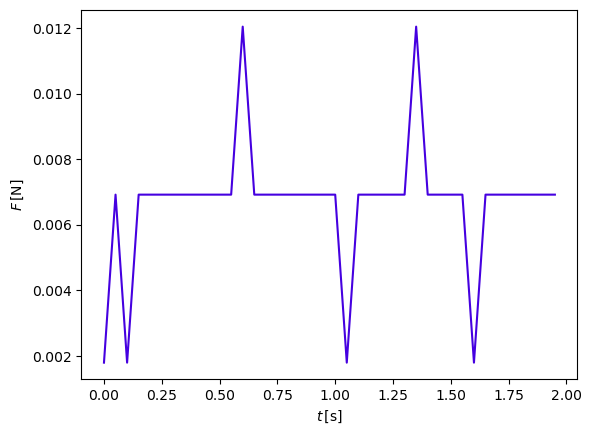

In [4]:
t, data = Snsr.measure(2)
plt.plot(t,data)
plt.xlabel(r"$t\,[\mathrm{s}]$")
plt.ylabel(r"$F\,[\mathrm{N}]$")

In [5]:
import MecaClass
importlib.reload(MecaClass)
from MecaClass import MecaClass

m = MecaClass()

2026-01-08 13:00:12 [INFO]: Robot IP: %s


In [6]:
m.connect()

2026-01-08 13:00:12 [INFO]: Connecting to robot 192.168.0.100:10000 (control mode)
2026-01-08 13:00:12 [INFO]: Connected to 192.168.0.100: Meca500 R4 M500-2128 v10.2.1.8120-official
2026-01-08 13:00:12 [INFO]: Activating
2026-01-08 13:00:13 [INFO]: Robot is activated.
2026-01-08 13:00:13 [INFO]: Robot activated
2026-01-08 13:00:13 [INFO]: Homing
2026-01-08 13:00:13 [INFO]: Robot at home
2026-01-08 13:00:13 [INFO]: Applying config parameters
2026-01-08 13:00:13 [INFO]: Applied SetCartLinVel(20.0,)
2026-01-08 13:00:13 [INFO]: Applied SetJointVel(10.0,)
2026-01-08 13:00:13 [INFO]: Applied SetJointAcc(20.0,)
2026-01-08 13:00:13 [INFO]: Applied SetBlending(0,)
2026-01-08 13:00:13 [INFO]: Config parameters done
2026-01-08 13:00:13 [INFO]: Current arm position: %s


## Check Robot movement

In [7]:
m.set_TRF_wrt_holder()

In [9]:
m.robot.MoveLin(180,0 , 95.15575, 180, 0, 0)

In [ ]:
points = (180, 0, 0)
m.move_lin(points)

## Training

In [ ]:
for t in range(Supervisor.T):
    Supervisor.draw_measurement(t)
    print('tip position = ', Supervisor.tip_pos)
    m.move_lin(Supervisor.tip_pos)
    mean_force = Snsr.mean_force(Snsr.measure())
    print('mean force = ', mean_force)

In [ ]:
m.disconnect()

## Logging - fixed arm

In [ ]:
experiments.sweep_measurement_fixed_origami(x_range, y_range, theta_range, N, robot, force_sensor)

## Calibrate forces

In [ ]:
importlib.reload(experiments)

weights = [1, 2, 5, 10, 20, 50, 200]
voltages_vec, forces_vec, stds_vec, fit_params = experiments.calibrate_forces(Snsr, weights)

## End of day

In [10]:
m.robot.MoveLin(40, 0, 230, 180, 0, 0)

In [11]:
m.disconnect()

2026-01-08 13:00:45 [INFO]: Disconnecting from the robot.
